# Introduction

In this benchmarking challenge, you will be tasked to create an [AutoRA experimentalist](https://autoresearch.github.io/autora/experimentalist/) that efficiently samples experiments in order to advance model discovery.

You can use this notebook to benchmark your experimentalist. Here, we will simulate a discovery experiment in which three different theorists are at work after each data collection cycle. You get to try out your experimentalist for two different ground truth models.

## Workflow

Your goal is to optimize the data collection process in the following workflow:

1. Sample 10 initial data points
2. Fit all theorists to those data points.

For 20 data points:
3. Pick a single novel data point using your experimentalist method. Your method may or may not take into account any of the theorists' models.
4. Add the data point to the experiment data.
5. Fit all theorists to the experiment data
6. Repeat steps 3-6 until 20 data points were collected

This workflow can be repeated two ground-truth models.








## Benchmarking Challenge Rules

- All contributing teams must publish a pip package of their experimentalist (we recommend using a pre-release) or have a working git repository that can be installed via ``!pip install git+https://github.com/musslick/autora-experimentalist-example``
- The package name must be ``autora-experimentalist-yourexperimentalist``
- The **experimentalist must have a sample function (see [this guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/))**, and it must be **compatible with the state logic** in this notebook.

- Teams will be ranked based on the final fit to a ground-truth model. Observations will be sampled across the entire domain of the ground-truth model. The rank will be accumulated across all benchmarking challenges. The team with the best accumulated rank will win a prize at the end of the workshop.
- The teams must provide a **brief presentation** (less than 5 minutes) of their experimentalist just before the final evaluation. You may use [this template for your slides](https://docs.google.com/presentation/d/1qCKqH9uXkQmGqDmROh1Jn4UcauALkMRhqlbAHubns2Q/edit?usp=sharing).

*Hint: You may take some inspiration (or come up with a combination of) the [existing experimentalists](https://autoresearch.github.io/autora/experimentalist/).*

## Grading

- Due date: **August 30**
- Submission: Through ``Stud.IP -> Tasks -> Experiment Sampling Challenge``

The grading is independent of the outcome of the benchmarking challenge.

The following points will be provided:
- A demonstration of the theorist in the ``doc/Basic Usage.ipynb``:
  -  2 points: Demonstrating how to use the experimentalist for sampling
  -  8 points: Demonstrating how the expeirmentalist compares to random sampling. This should be done by simulating closed-loop discovery process with a theorist of your choice (e.g., autora-theorist-bms) on at least two ground-truth models (*Hint: You could use the benchmarking part of the notebook below as a starting point*).
- The documentation of the experimentalist in ``doc/index.md`` must speak to the following information:
  - 2 points: the inputs: Which inputs is your experiment sampling method considering and why?
  - 2 points: sampling method: which sampling method are you using and why?
- 2 points: The code contains at least two useful unit tests for the experimentalist method (either doc tests or separate tests)
- 1 point: the contributors used issues to track bugs and work on features.
- 1 point: the contributors used (helpful) code reviews for their PRs.
- 1 point: Unit tests are automatically executed when a pull request is created.
- 1 point: The documentation is hosted automatically.

Finally, teams must outline the contributions of each team member in their submission on ``Stud.IP -> Tasks -> Experiment Sampling Challenge``.

In total, you can obtain 20 points.

## Additional Resources

- You can learn more about how to write AutoRA experimentalists in the [Contributor Guide](https://autoresearch.github.io/autora/contribute/modules/experimentalist/).

- You can learn more about how to use AutoRA in the [User Tutorial](https://autoresearch.github.io/autora/tutorials/).

- If you want to learn more about AutoRA states, you can check out [this tutorial on using AutoRA states](https://colab.research.google.com/drive/1yK1OBRpPZM1NgTMV9arHlE5j8xXjsGqq?usp=sharing).

# Code for Benchmarking your Experimentalist

## *Installation [EDIT HERE]

*Hint: You may want to add ``autora`` as a development dependency in your ``pyproject.tml``.*

In [1]:
%%capture
!pip install autora
!pip install autora[all-theorists]
!pip install autora[all-experimentalists]

# ADD YOUR GITHUB REPO LINK HERE
!pip install git+https://github.com/MoAljam/autora-experimentalist-challenge-g-1

## Imports

In [2]:
from autora.experimentalist.adaptable import adaptable_sample
from autora.experimentalist.progressive import progressive_sample
from autora.experimentalist.progressive_multi import progressive_multi_sample
from autora.experimentalist.confirmation import confirmation_sample, confirmation_score_sample
from tqdm import tqdm

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample, falsification_score_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample, model_disagreement_score_sample
from autora.experimentalist.uncertainty import uncertainty_sample
from autora.experimentalist.novelty import novelty_sample, novelty_score_sample
from autora.experimentalist.mixture import mixture_sample

import logging


In [3]:
# autora state
from autora.state import State, StandardState, on_state, estimator_on_state, Delta, VariableCollection

# experiment_runner
from autora.experiment_runner.synthetic.neuroscience.task_switching import task_switching

# experimentalist
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_pool, random_sample
from autora.experimentalist.falsification import falsification_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample

# theorist
from autora.theorist.bms import BMSRegressor

# sklearn
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, List


## AutoRA Components & State Wrappers

First, we will need some theorists. Here, we will use three theorists simultaneously:
- the Bayesian Machine Scientist
- a polynomial theorist (from the Equation Discovery Challenge)
- a linear regression theorist.

### Polynomial Theorist

Below, we will use a polynomial theorist for our discovery simulation. We saw that it did quite well in the equation discovery challenge, so why not give it a try.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class PolynomialRegressor:
    """
    This theorist fits a polynomial function to the data.
    """

    def __init__(self, degree: int = 3):
      self.poly = PolynomialFeatures(degree=degree, include_bias=False)
      self.model = LinearRegression()

    def fit(self, x, y):
      features = self.poly.fit_transform(x, y)
      self.model.fit(features, y)
      return self

    def predict(self, x):
      features = self.poly.fit_transform(x)
      return self.model.predict(features)

    def print_eqn(self):
        # Extract the coefficients and intercept
        coeffs = self.model.coef_
        intercept = self.model.intercept_

        # Handle multi-output case by iterating over each output's coefficients and intercept
        if coeffs.ndim > 1:
            for idx in range(coeffs.shape[0]):
                equation = f"y{idx+1} = {intercept[idx]:.3f}"
                feature_names = self.poly.get_feature_names_out()
                for coef, feature in zip(coeffs[idx], feature_names):
                    equation += f" + ({coef:.3f}) * {feature}"
                print(equation)
        else:
            equation = f"y = {intercept:.3f}"
            feature_names = self.poly.get_feature_names_out()
            for coef, feature in zip(coeffs, feature_names):
                equation += f" + ({coef:.3f}) * {feature}"
            print(equation)



### AutoRA State

Next, we define our AutoRA state which acts as modifiable "bucket" for all the data we are going to collect during the discovery cycle. Here, we will implement a more complicated AutoRA experiment in which we have simutlaneously fit 3 models (from 3 different theorists) and we want to keep track of all of them.

In [5]:
# SET UP STATE
# Here, we use a non-standard State to be able to use a multiple models
@dataclass(frozen=True)
class CustomState(State):
    variables: Optional[VariableCollection] = field(
        default=None, metadata={"delta": "replace"}
    )
    conditions: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "replace", "converter": pd.DataFrame}
    )
    experiment_data: Optional[pd.DataFrame] = field(
        default=None, metadata={"delta": "extend", "converter": pd.DataFrame}
    )
    models_bms: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_lr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )
    models_polyr: List[BaseEstimator] = field(
        default_factory=list,
        metadata={"delta": "extend"},
    )

### AutoRA State Wrappers

Next, we need to define a bunch of wrappers. These wrappers will make it easy to operate on the state. They specify which things are being pulled from the state and which things are being stored.

#### Theorist Wrapper

In [6]:
# state wrapper for all theorists
@on_state()
def theorists_on_state(experiment_data, variables, bms_epochs):

  # extract conditions X and observations y from experiment data
  ivs = [iv.name for iv in variables.independent_variables]
  dvs = [dv.name for dv in variables.dependent_variables]
  X = experiment_data[ivs]
  y = experiment_data[dvs]

  # initialize and fit theorists
  theorist_bms = BMSRegressor(epochs=bms_epochs)
  theorist_polyr = PolynomialRegressor()
  theorist_lr = linear_model.LinearRegression()

  return Delta(models_bms = [theorist_bms.fit(X, y)],
               models_lr=[theorist_lr.fit(X, y)],
               models_polyr=[theorist_polyr.fit(X, y)])

#### *Experimentalist Wrappers [EDIT HERE]

In [7]:
# state wrapper for grid pooler experimentalist (generates a grid of experiment conditions)
@on_state()
def grid_pool_on_state(variables):
  return Delta(conditions=grid_pool(variables))

# state wrapper for random pooler experimentalist (generates a pool of experiment conditions)
@on_state()
def random_pool_on_state(variables, num_samples, random_state=None):
  return Delta(conditions=random_pool(variables, num_samples, random_state))

# state wrapper for random experimentalist (samples experiment conditions from a set of conditions)
@on_state()
def random_sample_on_state(conditions, all_conditions, num_samples, random_state=None):
  return Delta(conditions=random_sample(all_conditions, num_samples, random_state))

# **** STATE WRAPPER FOR YOUR EXPERIMENTALIST ***
@on_state()
def custom_sample_on_state(
    experiment_data,
    variables,
    models_bms,
    models_lr,
    models_polyr,
    all_conditions,
    cycle=None,
    max_cycle=None,
    num_samples=1,
    random_state=None,
):
    # temperature(0-1) to determine the progress of the discovery process
    temperature = cycle / max_cycle
    temperature = np.clip(temperature, 0, 1)

    # get the input relevant to some of the samplers
    # independent and dependent variables for the metadata
    iv = variables.independent_variables
    dv = variables.dependent_variables
    meta_data = VariableCollection(independent_variables=iv, dependent_variables=dv)

    # reference conditions and observations
    ivs = [iv.name for iv in variables.independent_variables]
    dvs = [dv.name for dv in variables.dependent_variables]
    reference_conditions = experiment_data[ivs]
    reference_observations = experiment_data[dvs]

    # remove the conditions that have already been sampled from the conditions pool
    # remove reference conditions from the conditions pool
    if isinstance(all_conditions, pd.DataFrame) and isinstance(reference_conditions, pd.DataFrame):
        conditions_pool = pd.concat([all_conditions, reference_conditions])
        conditions_pool = conditions_pool.drop_duplicates(keep=False)
    else:
        conditions_pool = all_conditions[~all_conditions.isin(reference_conditions)].dropna()

    # NOTE: the sampler is performeing a bit worse when including falsification and confirmation
    #       possiblly due to passing only one model to theses samplers
    #       while the performance is based on 3 models
    samplers = [
        {
            "func": novelty_score_sample,
            "name": "novelty",
            "params": {"reference_conditions": reference_conditions},
        },
        # {
        #     "func": falsification_score_sample,
        #     "name": "falsification",
        #     "params": {
        #         "reference_conditions": reference_conditions,
        #         "reference_observations": reference_observations,
        #         "metadata": meta_data,
        #         "model": models_polyr[-1],
        #     },
        # },
        {
            "func": model_disagreement_score_sample,
            "name": "model_disagreement",
            "params": {
                "models": [models_bms[-1], models_lr[-1], models_polyr[-1]],
            },
        },
        {
            "func": confirmation_score_sample,
            "name": "confirmation",
            "params": {
                "reference_conditions": reference_conditions,
                "reference_observations": reference_observations,
                "metadata": meta_data,
                "model": models_polyr[-1],
            },
        },
    ]
    # samplers_coords = [0, 1, 3, 4, 6]  # optional
    # samplers_coords = [1, 2, 5]
    # samplers_coords = [0, 2, 3, 5]

    adaptable_sampler_sensitivity = 14

    new_conditions = adaptable_sample(
        conditions=conditions_pool,
        reference_conditions=reference_conditions,
        models=models_polyr,  # pass only the polyr models
        samplers=samplers,
        num_samples=num_samples,
        # samplers_coords=samplers_coords,
        sensitivity=adaptable_sampler_sensitivity,
        plot=False,
    )

    # new_conditions = progressive_sample(
    #     conditions=all_conditions,
    #     num_samples=num_samples,
    #     # models=[models_lr[-1], models_polyr[-1]],
    #     temprature=temperature,
    #     samplers=samplers,
    #    # samplers_coords=samplers_coords,
    # )

    return Delta(conditions=new_conditions)


#### Experiment Runner Wrapper

In [8]:
# state wrapper for synthetic experiment runner
@on_state()
def run_experiment_on_state(conditions, experiment_runner):
  data = experiment_runner.run(conditions=conditions, added_noise=0.0)
  return Delta(experiment_data=data)

## Simulation Functions

First, we will need a function that we can use to evaluate the goodness of our theorists. We will use the one below (no need to parse it).

In [9]:
# the following function is used to compute the model performance
# on the validation set in terms of mean squared error
def get_validation_MSE(validation_experiment_data, working_state):
    ivs = [iv.name for iv in validation_experiment_data.variables.independent_variables]
    dvs = [dv.name for dv in validation_experiment_data.variables.dependent_variables]
    X = validation_experiment_data.experiment_data[ivs]
    y = validation_experiment_data.experiment_data[dvs]

    y_pred_bms = working_state.models_bms[-1].predict(X)
    y_pred_lr = working_state.models_lr[-1].predict(X)
    y_pred_polyr = working_state.models_polyr[-1].predict(X)

    MSE_bms = ((y - y_pred_bms)**2).mean()[0]
    MSE_lr = ((y - y_pred_lr)**2).mean()[0]
    MSE_polyr = ((y - y_pred_polyr)**2).mean()[0]

    min_MSE = min(MSE_bms, MSE_lr, MSE_polyr)

    return min_MSE

We will use the following function for benchmarking our model for any given experiment runner. Have a closer look at the script below.

It uses four different AutoRA states:
- ``validation_conditions`` and ``validation_experiment_data``: These states contains our validation sets, sampled across the entire domain of the ground truth. It is used for tracking the validation MSE of all theorists.

- ``initial_state``: This state is used to initialize the discovery process. Both the random experimentalist (operating on the ``benchmark_state``) and your custom experimentalist (operating on the ``working_state`` will use the same initial state.)

- ``benchmark_state``: This state is used for a discovery process with random sampling.

- ``working_state``: This state is used for a discovery process with your custom experimentalist.

In [10]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# region run simulation
def run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim=0):
    # VALIDATION STATE
    # at every step of our discovery process, we will evaluate the performance
    # of the theorist against the ground truth. Here, we will define the ground
    # truth as a grid of data points sampled across the domain of the experimental
    # design space. We will store this validation set in a separate validation states

    # create AutoRA state for validation purposes
    # validation_conditions = CustomState(variables=experiment_runner.variables)
    # validation_experiment_data = CustomState(variables=experiment_runner.variables)

    # # our validation set will be consist of a grid of experiment conditons
    # # across the entire experimental design domain
    # validation_conditions = grid_pool_on_state(validation_conditions)
    # validation_experiment_data = grid_pool_on_state(validation_experiment_data)
    # validation_experiment_data = run_experiment_on_state(
    #     validation_experiment_data, experiment_runner=experiment_runner
    # )

    with ThreadPoolExecutor(max_workers=2) as executor:
        validation_conditions_future = executor.submit(
            grid_pool_on_state, CustomState(variables=experiment_runner.variables)
        )
        validation_experiment_data_future = executor.submit(
            grid_pool_on_state, CustomState(variables=experiment_runner.variables)
        )

    validation_conditions = validation_conditions_future.result()
    validation_experiment_data = run_experiment_on_state(
        validation_experiment_data_future.result(), experiment_runner=experiment_runner
    )

    benchmark_MSE_log = list()
    working_MSE_log = list()

    # INITIAL STATE
    # We begin our discovery experiment with randomly sampled data set for 10
    # conditions. We will use the same state for each experimentalist method.

    # create initial AutoRA state which we will use for our discovery expeirments
    initial_state = CustomState(variables=experiment_runner.variables)

    # we will initiate our discovery process with 10 randomly sampled experiment conditions
    initial_state = random_pool_on_state(initial_state, num_samples=num_initial_conditions, random_state=sim)

    # we obtain the corresponding experiment data
    initial_state = run_experiment_on_state(initial_state, experiment_runner=experiment_runner)

    # initialize benchmark state for random experimentalist
    benchmark_state = CustomState(**initial_state.__dict__)

    # initialize working state for your custom experimentalist
    working_state = CustomState(**initial_state.__dict__)

    # for each discovery cycle
    for cycle in tqdm(range(num_cycles), leave=True, desc="discovery cycles"):

        print("SIMULATION " + str(sim) + " / DISCOVERY CYCLE " + str(cycle))

        # first, we fit a model to the data
        # print("Fitting models on benchmark state...")
        # benchmark_state = theorists_on_state(benchmark_state, bms_epochs=bms_epochs)
        # print("Fitting models on working state...")
        # working_state = theorists_on_state(working_state, bms_epochs=bms_epochs)

        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_future = executor.submit(theorists_on_state, benchmark_state, bms_epochs=bms_epochs)
            working_future = executor.submit(theorists_on_state, working_state, bms_epochs=bms_epochs)

        benchmark_state = benchmark_future.result()
        working_state = working_future.result()

        # now we can determine how well the models do on the validation set
        # benchmark_MSE = get_validation_MSE(validation_experiment_data, benchmark_state)
        # benchmark_MSE_log.append(benchmark_MSE)

        # working_MSE = get_validation_MSE(validation_experiment_data, working_state)
        # working_MSE_log.append(working_MSE)

        # MSE calculation in parallel
        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_MSE_future = executor.submit(get_validation_MSE, validation_experiment_data, benchmark_state)
            working_MSE_future = executor.submit(get_validation_MSE, validation_experiment_data, working_state)

        benchmark_MSE_log.append(benchmark_MSE_future.result())
        working_MSE_log.append(working_MSE_future.result())

        # then we determine the next experiment condition
        # print("Sampling new experiment conditions...")
        # benchmark_state = random_sample_on_state(
        #     benchmark_state, all_conditions=validation_conditions.conditions, num_samples=num_conditions_per_cycle
        # )
        # working_state = custom_sample_on_state(
        #     working_state,
        #     all_conditions=validation_conditions.conditions,
        #     num_samples=num_conditions_per_cycle,
        #     cycle=cycle,
        #     max_cycle=num_cycles,
        # )

        # print("Obtaining observations...")
        # # we obtain the corresponding experiment data
        # benchmark_state = run_experiment_on_state(benchmark_state, experiment_runner=experiment_runner)
        # working_state = run_experiment_on_state(working_state, experiment_runner=experiment_runner)

        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_sample_future = executor.submit(
                random_sample_on_state,
                benchmark_state,
                all_conditions=validation_conditions.conditions,
                num_samples=num_conditions_per_cycle,
            )
            working_sample_future = executor.submit(
                custom_sample_on_state,
                working_state,
                all_conditions=validation_conditions.conditions,
                num_samples=num_conditions_per_cycle,
                cycle=cycle,
                max_cycle=num_cycles,
            )

        benchmark_state = benchmark_sample_future.result()
        working_state = working_sample_future.result()

        with ThreadPoolExecutor(max_workers=2) as executor:
            benchmark_experiment_future = executor.submit(
                run_experiment_on_state, benchmark_state, experiment_runner=experiment_runner
            )
            working_experiment_future = executor.submit(
                run_experiment_on_state, working_state, experiment_runner=experiment_runner
            )

        benchmark_state = benchmark_experiment_future.result()
        working_state = working_experiment_future.result()

    return benchmark_MSE_log, working_MSE_log, benchmark_state, working_state


## Benchmarking Script

Let's first set some meta-parameters.

In [11]:
# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1

# YOU MAY CHANGE THESE PARAMETERS
num_discovery_simulations = 10
bms_epochs = 100 # Note, to speed things up, you can set bms_epochs = 10 or even bms_epochs = 1 (this will lead to poor performance of the BMS regressor but the other two theorists will still fit)

### Single Run (not used for validation)

We recommend that you probe your experimentalist function for a single run. Once you are confident that your experimentalist works, we recommend running repeating the simulation experiment for at least iterations (``num_discovery_simulations``).

How do your results look like for other ground truths, such as
- ``luce_choice_ratio()`` or
- ``expected_value_theory()`` ?

In [ ]:
logging.basicConfig(level=logging.CRITICAL)
# setting experiment runner and theorist
experiment_runner = task_switching()

# run simulation
benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner)


We can now plot the results for a single discovery run.

    cur_task_strength  alt_task_strength  is_switch  cur_task_performance
0                0.86               0.64          1              0.592120
1                0.28               0.92          1              0.440713
2                0.34               0.68          1              0.491471
3                0.24               0.02          1              0.751508
4                0.78               0.90          0              0.651694
5                0.42               0.24          0              0.894024
6                0.82               0.02          0              0.983827
7                0.52               0.16          0              0.940818
8                0.06               0.22          0              0.808168
9                0.32               0.72          1              0.481478
10               0.46               0.82          1              0.463298
11               0.26               0.56          0              0.686704
12               0.56               0.

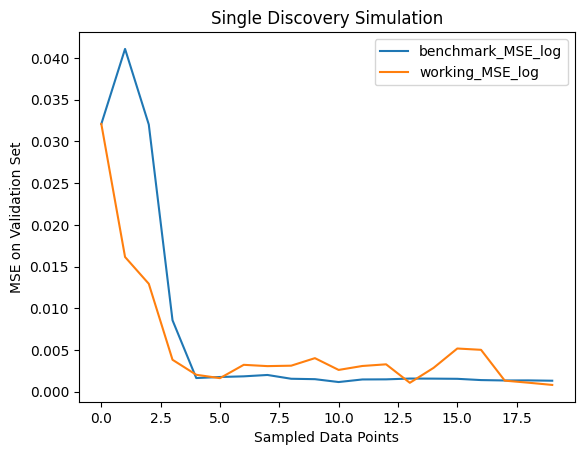

In [13]:
# lets plot the benchmark_MSE_log and the workign_MSE_log
plt.plot(benchmark_MSE_log, label='benchmark_MSE_log')
plt.plot(working_MSE_log, label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Single Discovery Simulation')
plt.legend()

# we can also investigate the final state more closely
# for example, these are all the experimental data collected
# under random sampling:
print(benchmark_state.experiment_data)
# and for your custom experimentalist
print(working_state.experiment_data)

### Averaging Across Multiple Runs [USED FOR VALIDATION]

To become more confident in your experimentalist, you may want to repeat the discovery process N times...

In [ ]:
logging.basicConfig(level=logging.CRITICAL)

# meta parameters

# DO NOT CHANGE THESE PARAMETERS
num_cycles = 20
num_conditions_per_cycle = 1
num_initial_conditions = 1
num_discovery_simulations = 20
bms_epochs = 100

# setting experiment runner and theorist
experiment_runner = task_switching()

benchmark_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])
working_MSE_plot_data = np.zeros([num_discovery_simulations, num_cycles])

for sim in range(num_discovery_simulations):
  benchmark_MSE_log, working_MSE_log, benchmark_state, working_state = run_simulation(num_cycles, num_conditions_per_cycle, num_initial_conditions, bms_epochs, experiment_runner, sim)

  benchmark_MSE_plot_data[sim, :] = benchmark_MSE_log
  working_MSE_plot_data[sim, :] = working_MSE_log

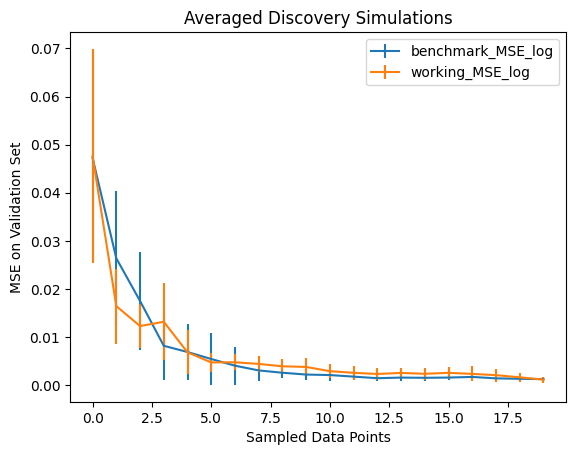

In [15]:
# plot the data with standard error
plt.errorbar(np.arange(num_cycles), np.mean(benchmark_MSE_plot_data, axis=0), yerr=np.std(benchmark_MSE_plot_data, axis=0), label='benchmark_MSE_log')
plt.errorbar(np.arange(num_cycles), np.mean(working_MSE_plot_data, axis=0), yerr=np.std(working_MSE_plot_data, axis=0), label='working_MSE_log')
plt.xlabel('Sampled Data Points')
plt.ylabel('MSE on Validation Set')
plt.title('Averaged Discovery Simulations')
plt.legend()

In [24]:
print(np.sum(np.mean(working_MSE_plot_data, axis=0)))

0.14047810274022263


In [17]:
np.mean(working_MSE_plot_data, axis=0)


array([0.04761697, 0.01644087, 0.01228641, 0.01318007, 0.00682447,
       0.00473164, 0.00475838, 0.0044168 , 0.00392596, 0.00379017,
       0.00291252, 0.00256868, 0.00233144, 0.00254474, 0.002369  ,
       0.0025642 , 0.00234586, 0.00208275, 0.00163372, 0.00115345])

## Ground Truth Model Descriptions

### Task Switching

One of the most robust findings in cognitive psychology is that individuals make fewer errors and respond more slowly when repeating a task as compared to switching from one task to another. Yeung & Monsell (2003) explain this and other task-switching phenomena with a simple model in which the activation level of a task is related to its performance,

$
    P(\text{Correct Response to Task A}) = \frac{e^{1/T \cdot {act_A}}}{e^{1/T \cdot {act_A}} + e^{1/T \cdot {act_B}}}.
$

 where $T = 0.2$ is the choice temperature, and $act_A$ and $act_B$ correspond to the activity of tasks A and B, respectively. The activity of any task is a non-linear function of its input, $act_i = 1 - e^{1.5 \cdot \text{input}_i}$. The input consists of multiple factors,

$
     \text{input}_i = \text{strength}_i + \text{priming} \cdot \text{repetition} + \text{control}(i) + \epsilon
$

including the degree of task practice, represented as $\text{strength}_i$, and a priming factor, which is incorporated when the task on the current experimental trial is identical to that of the previous trial ($\text{repetition} = 1$). Additionally, endogenous control is incorporated into the task input as a function of the task's strength (see Yeung & Monsell (2003) for more details). Finally, noise $\epsilon \sim N(0, 0.01^2)$ is added to the input. For the simulations reported below, we parameterized the model according to Table 4 in Yeung & Monsell (2003).

The three experimental factors of the task switching model are the strengths of the two tasks, $\text{strength}_i \in \{ 0.02k \mid k \in \{1, \ldots, 100\}\}$, and the type of task transition, $\text{repetition} \in \{0,1\}$. We considered the probability of correctly responding to {Task A} as the dependent variable of interest.